In [425]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [426]:
# arguments for training
args = {'lr':0.005,
        'epochs':5000, # layer 1 and 11 improve with 5000+ epochs but runs super slow
        'noise':0.01,
        'train size':1800,
        'spec scale':10**12,
        'loss function':nn.L1Loss(),
        'optimizer function': torch.optim.Adam
        }

num_layers = 11

In [427]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Preparing Data

In [428]:
df = pd.read_excel('wide_range.xlsx')
df

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,...,7.55e-06,7.6e-06,7.65e-06,7.7e-06,7.75e-06,7.8e-06,7.85e-06,7.9e-06,7.95e-06,8e-06
0,364.787366,317.684838,313.810126,303.307879,314.323118,317.828320,318.557698,308.808121,309.953331,296.299100,...,2.291410e-12,2.333930e-12,2.371461e-12,2.402093e-12,2.424702e-12,2.433566e-12,2.417632e-12,2.365972e-12,2.285583e-12,2.211520e-12
1,342.552920,335.048875,325.169322,323.807685,312.667938,307.509532,318.808960,312.412740,305.472749,315.420270,...,1.639899e-12,1.669825e-12,1.698490e-12,1.723560e-12,1.743375e-12,1.753393e-12,1.745497e-12,1.711668e-12,1.656824e-12,1.606307e-12
2,314.150653,325.319947,330.529579,337.855852,336.525836,349.311552,336.370506,342.758437,344.195955,333.964029,...,4.487510e-12,4.550427e-12,4.603621e-12,4.643395e-12,4.667637e-12,4.665521e-12,4.616247e-12,4.499595e-12,4.329608e-12,4.173042e-12
3,302.513193,306.523372,315.214925,315.629483,313.136991,312.378427,319.314782,302.018575,306.730069,310.949569,...,2.760638e-12,2.807683e-12,2.849087e-12,2.882405e-12,2.906159e-12,2.913462e-12,2.891133e-12,2.826217e-12,2.727201e-12,2.635977e-12
4,332.142887,315.836569,320.947657,325.884656,338.307720,339.673089,334.705064,325.483513,321.166972,307.175291,...,3.121194e-12,3.173340e-12,3.218273e-12,3.253581e-12,3.277914e-12,3.283670e-12,3.256076e-12,3.180625e-12,3.066965e-12,2.962253e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,335.977302,330.241682,343.703154,340.218015,330.146201,328.147822,327.013308,324.117365,328.765182,349.809711,...,3.492639e-12,3.541544e-12,3.586094e-12,3.622037e-12,3.646522e-12,3.650482e-12,3.617422e-12,3.531303e-12,3.402929e-12,3.284666e-12
2196,295.379242,293.251102,296.318163,309.705578,316.303984,321.883308,335.052888,332.051792,332.335927,338.805641,...,4.885042e-12,4.950908e-12,5.006120e-12,5.046707e-12,5.070411e-12,5.065506e-12,5.009465e-12,4.880432e-12,4.693737e-12,4.521797e-12
2197,302.147937,330.381158,325.654767,339.596050,340.118082,331.556311,345.541835,346.354970,336.491525,344.553594,...,2.505269e-12,2.542833e-12,2.578975e-12,2.609906e-12,2.632938e-12,2.641187e-12,2.622551e-12,2.565215e-12,2.476821e-12,2.395382e-12
2198,291.079250,297.187368,316.074457,317.549974,316.173049,333.928034,328.743984,333.894228,331.093773,324.365239,...,1.138944e-12,1.158522e-12,1.179434e-12,1.199129e-12,1.215649e-12,1.225428e-12,1.222663e-12,1.201639e-12,1.165695e-12,1.132607e-12


In [429]:
# first columns of excel sheet is temperature data, then spectral data
y = df.iloc[:,:num_layers]
X = df.iloc[:,num_layers:]

# scale the spectral data appropriately
X = X.apply(lambda x: x*args['spec scale'])

clean_X = X.copy() # data with no noise

# add noise to other X data
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X = X + noise

# split the data for training and testing
X_train = X.iloc[:args['train size'], :]
clean_X_train = clean_X.iloc[:args['train size'], :]
y_train = y.iloc[:args['train size'], :]

X_test = X.iloc[args['train size']:, :]
clean_X_test = clean_X.iloc[args['train size']:, :]
y_test = y.iloc[args['train size']:, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

# index the data
X_train.index = range(len(X_train))
X_test.index = range(len(X_test))
clean_X.index = range(len(clean_X))

In [430]:
# more training data
# less testing data
clean_X_train

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.058092,0.050960,0.067645,0.053079,0.073458,0.070581,0.109244,0.088127,0.132571,0.171505,...,5.559207,5.624286,5.680092,5.720913,5.743184,5.733194,5.665447,5.515370,5.300453,5.102552
1796,0.020865,0.017815,0.022672,0.017545,0.024215,0.023642,0.038249,0.033440,0.052788,0.071098,...,2.731465,2.776065,2.816257,2.849120,2.872770,2.880196,2.858326,2.794344,2.696633,2.606612
1797,0.023957,0.022099,0.031060,0.025120,0.035467,0.034308,0.052319,0.040247,0.059008,0.074613,...,1.257615,1.280629,1.303892,1.325103,1.342545,1.352494,1.348604,1.324601,1.284201,1.247003
1798,0.038770,0.035673,0.050047,0.040308,0.056641,0.054457,0.082382,0.062676,0.091149,0.114388,...,2.320425,2.355479,2.389728,2.419447,2.441954,2.450765,2.434611,2.382484,2.301435,2.226764


In [431]:
X_train

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.042939,0.029837,0.051606,0.043972,0.058557,0.051243,0.083454,0.052321,0.079675,0.122578,...,5.030863,5.087549,5.126798,5.173240,5.216420,5.199883,5.160699,4.997772,4.826796,4.648673
1,0.033491,0.011989,0.014555,0.025615,0.019674,0.006953,0.026479,0.024430,0.055753,0.057857,...,1.244332,1.241477,1.273251,1.313355,1.323658,1.332175,1.333406,1.296539,1.269854,1.225627
2,0.030301,0.015437,0.012136,0.028438,0.005741,0.029784,0.055282,0.039018,0.074785,0.083065,...,3.818892,3.879665,3.919249,3.955725,3.989528,4.008423,3.948495,3.850039,3.703478,3.585612
3,0.027663,0.002639,0.023377,0.037617,0.036821,0.017415,0.042097,0.007862,0.061289,0.063448,...,4.820098,4.917461,4.938740,5.003073,5.025125,5.010807,4.960673,4.850628,4.650646,4.479550
4,0.013854,0.015145,0.015413,0.027453,0.011570,0.037211,0.040131,0.017015,0.042796,0.052630,...,4.056269,4.099964,4.162259,4.190287,4.210387,4.242137,4.193470,4.067795,3.915048,3.775490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.005881,-0.007671,0.009695,0.025892,0.023801,0.002009,0.011188,0.014924,0.009354,0.044759,...,1.719895,1.766496,1.794036,1.828472,1.841565,1.859288,1.848845,1.803378,1.760738,1.698834
1796,0.032551,0.019176,0.030383,0.004262,0.024096,0.016830,0.043200,0.036903,0.052388,0.093732,...,1.875819,1.899845,1.947211,1.965357,1.990259,1.988671,1.983848,1.952706,1.882114,1.831056
1797,0.044900,0.057096,0.055487,0.038219,0.063442,0.061796,0.113388,0.066040,0.114055,0.143838,...,5.344924,5.418968,5.461638,5.514402,5.513331,5.525691,5.448658,5.317932,5.105355,4.912568
1798,0.031954,-0.009070,0.035266,0.021372,0.014058,-0.003936,0.026810,0.016585,0.041086,0.067624,...,2.584008,2.618048,2.650666,2.680357,2.702120,2.732726,2.698055,2.631684,2.540337,2.461904


# Creating and Training AE

In [432]:
# define AE
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size):
        super(Autoencoder, self).__init__()
        # encoder compresses the input data (noisy spectrum data) into a lower-dimensional representation (bottleneck)
        # starts as 86 ends as 5
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 75),
            nn.ReLU(),
            nn.Linear(75, 60),
            nn.ReLU(),
            nn.Linear(60, 45),
            nn.ReLU(),
            nn.Linear(45, 30),
            nn.ReLU(),
            nn.Linear(30, bottleneck_size),
        )
        # decoder reconstructs the input data (noisy spectrum data) from the bottleneck representation
        # starts as 5 ends as 86
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 30),
            nn.ReLU(),
            nn.Linear(30, 45),
            nn.ReLU(),
            nn.Linear(45, 60),
            nn.ReLU(),  
            nn.Linear(60, 75),
            nn.ReLU(),
            nn.Linear(75, input_size),
           
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# training ae
# set the input size, bottleneck size, and output size
input_size = 86 # or len(X_train.columns) # spectrum data points/columns
bottleneck_size = 5 
output_size = 1 # predicting one layer at a time

#print input and output size
print(f' input size: {input_size}, output size: {output_size}')

# create an instance of Autoencoder
autoencoder = Autoencoder(input_size, bottleneck_size)


def train_autoencoder(autoencoder, df, num_epochs, learning_rate):
    learning_rate = 0.01
    criterion = args['loss function']
    num_epochs = 500
    #optim = args['optimizer function']

# defining loss function and optimizer
    optimizer = torch.optim.Rprop(autoencoder.parameters(), lr=learning_rate)

# inputs 
    noisy_inputs =  df_to_tensor(X_train) # spectrum data with noise
    clean_inputs = df_to_tensor(clean_X_train) # spectrum data without noise

# training loop
    for epoch in range(num_epochs):
        # forward pass
        outputs = autoencoder(noisy_inputs) # outputs noisy data passed through ae
        loss = criterion(outputs, clean_inputs) # checks the loss between noisy data ran through ae and data without noise
      
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

train_autoencoder(autoencoder, df, num_epochs=500, learning_rate=0.01)


 input size: 86, output size: 1


KeyboardInterrupt: 

# Creating Sequential NN

In [ ]:
# adjusted model to connect AE
class SeqNet(nn.Module):
    def __init__(self, input_size, bottleneck_size, output_size):
        super(SeqNet, self).__init__()
        self.lin1 = nn.Linear(input_size, bottleneck_size)
        self.lin2 = nn.Linear(5, 75)
        self.lin3 = nn.Linear(75, 60)
        self.lin4 = nn.Linear(60, 5)
        self.lin_fin = nn.Linear(bottleneck_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = self.lin_fin(x)
        return x
    
# create an instance of SeqNet
seq_net = SeqNet(input_size, bottleneck_size, output_size)

In [ ]:
# define a dictionary with seperate models for each layer; change input_size appropriately
models = {}
for i in range(1, 12):
    models[f'model{i}'] = SeqNet(input_size + (-i+11), bottleneck_size, output_size)

print(models)

{'model1': SeqNet(
  (lin1): Linear(in_features=96, out_features=5, bias=True)
  (lin2): Linear(in_features=5, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=60, bias=True)
  (lin4): Linear(in_features=60, out_features=5, bias=True)
  (lin_fin): Linear(in_features=5, out_features=1, bias=True)
), 'model2': SeqNet(
  (lin1): Linear(in_features=95, out_features=5, bias=True)
  (lin2): Linear(in_features=5, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=60, bias=True)
  (lin4): Linear(in_features=60, out_features=5, bias=True)
  (lin_fin): Linear(in_features=5, out_features=1, bias=True)
), 'model3': SeqNet(
  (lin1): Linear(in_features=94, out_features=5, bias=True)
  (lin2): Linear(in_features=5, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=60, bias=True)
  (lin4): Linear(in_features=60, out_features=5, bias=True)
  (lin_fin): Linear(in_features=5, out_features=1, bias=True)
), 'model4': SeqNet(
  (lin1):

# Training Sequential NN

In [ ]:
learning_rate = args['lr']
criterion = args['loss function']
num_epochs = args['epochs']
optim = args['optimizer function']

In [ ]:
loss_lists = {}
prev_pred = None
prev_models = []
best_losses = []

noisy_inputs =  df_to_tensor(X_train) # spectrum data with noise
new_inputs = autoencoder(noisy_inputs) # new input for sequential network

# for layers
for i in range(num_layers):
    best_loss = np.inf

    layer = 11 - i
    print(f'Layer {layer}')

    # define loss list for each layer with loss_lists dictionary
    loss_lists[f'loss_list{layer}'] = []

    # freeze the parameters of the previous models
    for prev_model in prev_models:
        for param in prev_model.parameters():
            param.requires_grad = False

    # define the seq net corresponding to the given layer
    model = models[f'model{layer}']
    prev_models.append(model)

    # define optimizer corresponding to the given model
    optimizer = optim(models[f'model{layer}'].parameters(), lr=learning_rate)

    # add previous layer's predictions to inputs
    if i > 0:
        prev_pred = pred_temp.clone().detach().reshape(-1, 1)
        new_inputs = torch.cat([new_inputs, prev_pred], dim=1)

    # get expected_temp for the corresponding layer (use correct column of temperature data)
    expected_temp = df_to_tensor(y_train.iloc[:,layer-1]).reshape(-1,1)


# training loop for seq
    for epoch in range(num_epochs):
        # empty gradients
        optimizer.zero_grad()

        # forward pass 
        pred_temp = model(new_inputs) #ERROR HERE

        # calculate loss and add to loss list
        loss = criterion(pred_temp, expected_temp)
        loss_lists[f'loss_list{layer}'].append(loss.item())

        # backward pass
        loss.backward(retain_graph=True) 
        
        # update parameters based on computed gradients
        optimizer.step()
       
        # print losses
        if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')


        # find best loss
        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch + 1

    best_losses.append(best_loss.item())


Layer 11


epoch: 500, loss = 22.01894760131836
epoch: 1000, loss = 19.598257064819336
epoch: 1500, loss = 17.28773307800293
epoch: 2000, loss = 15.362847328186035
epoch: 2500, loss = 19.947080612182617
epoch: 3000, loss = 13.059433937072754
epoch: 3500, loss = 13.218737602233887
epoch: 4000, loss = 15.354043960571289
epoch: 4500, loss = 11.181429862976074
epoch: 5000, loss = 11.32362174987793
Layer 10
epoch: 500, loss = 14.09705638885498
epoch: 1000, loss = 13.715495109558105
epoch: 1500, loss = 12.757365226745605
epoch: 2000, loss = 11.519828796386719
epoch: 2500, loss = 11.227334022521973
epoch: 3000, loss = 11.197562217712402
epoch: 3500, loss = 11.120209693908691
epoch: 4000, loss = 11.119030952453613
epoch: 4500, loss = 11.169370651245117
epoch: 5000, loss = 11.04619026184082
Layer 9
epoch: 500, loss = 9.724717140197754
epoch: 1000, loss = 9.13449764251709
epoch: 1500, loss = 9.100329399108887
epoch: 2000, loss = 9.052642822265625
epoch: 2500, loss = 9.100022315979004
epoch: 3000, loss = 9.

# Plot Losses

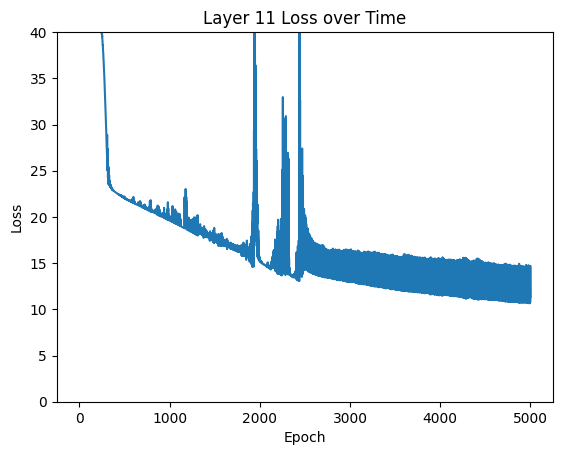

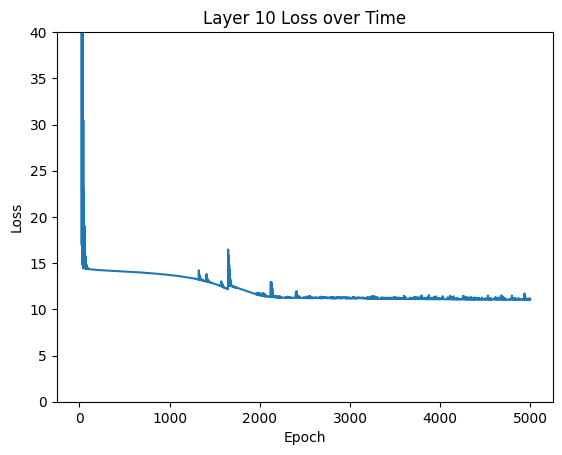

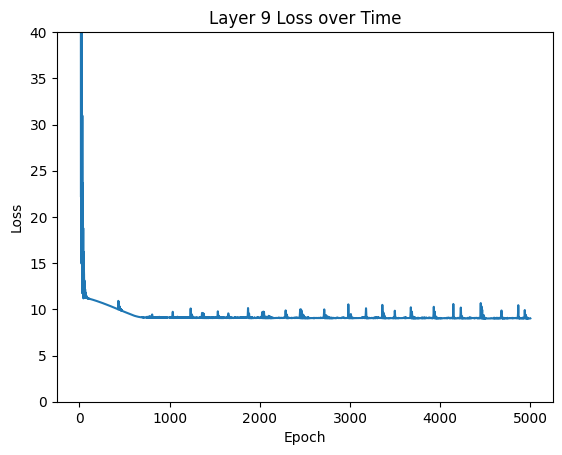

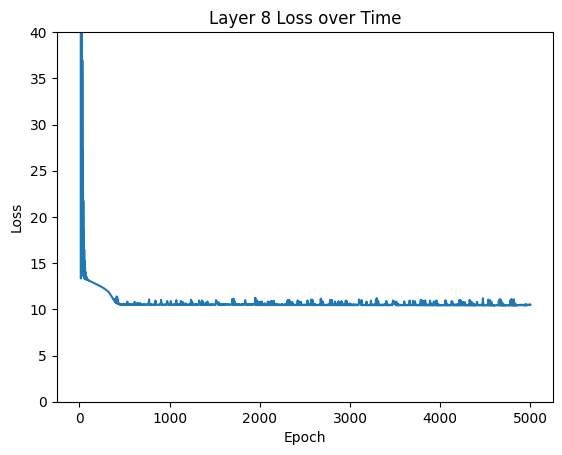

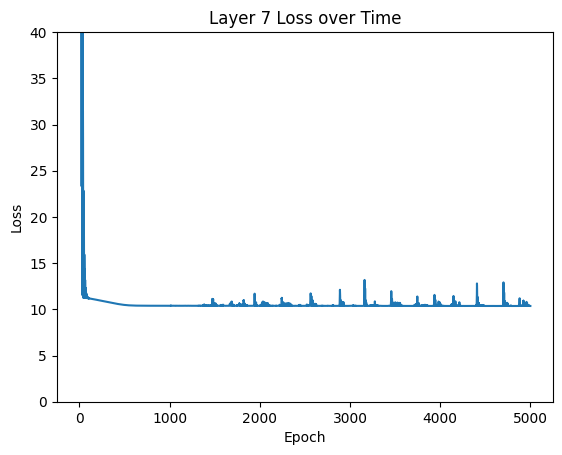

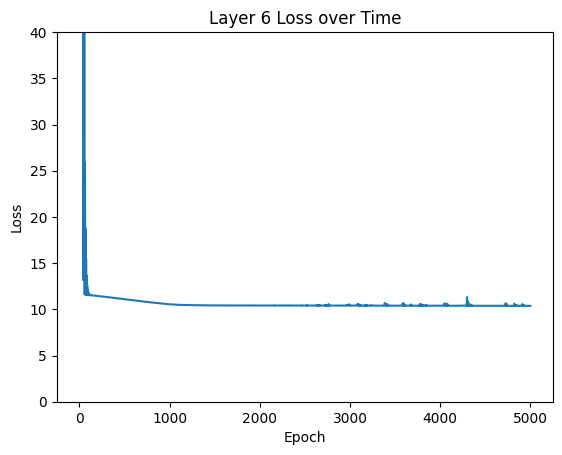

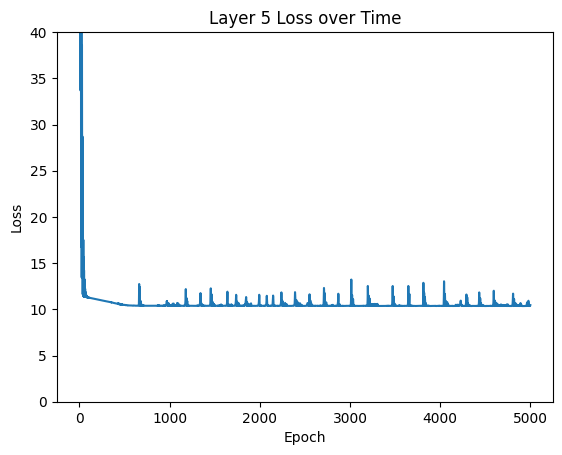

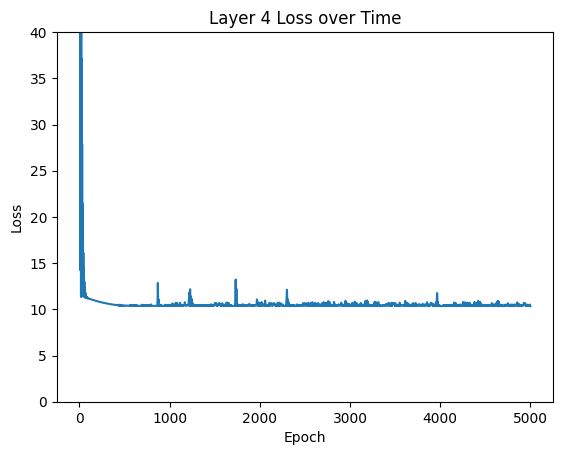

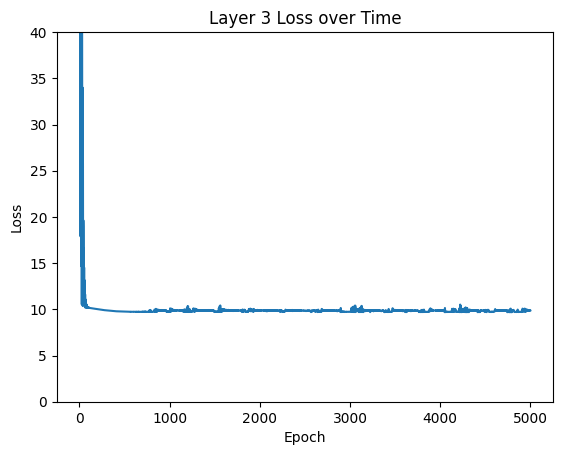

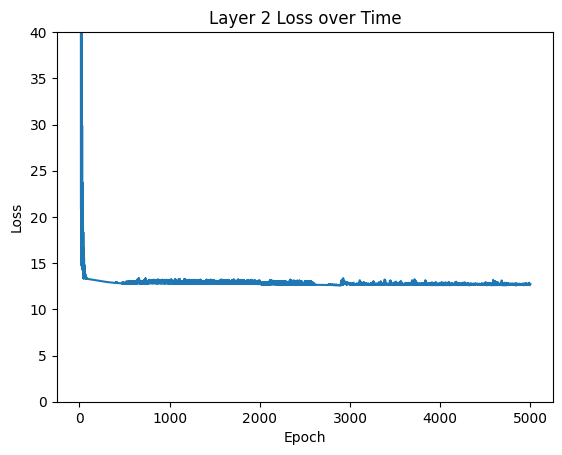

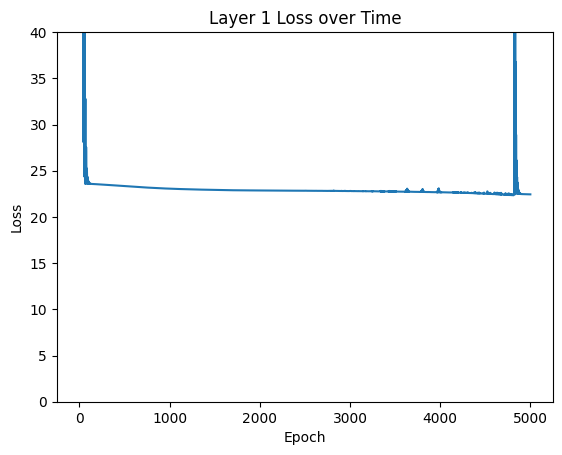

In [ ]:
# plot loss over time for each layer

for i in range(num_layers):
    layer = 11 - i
    plt.plot(loss_lists[f'loss_list{layer}'])
    
    plt.title(f'Layer {layer} Loss over Time')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # limit graph to max loss of 40 (otherwise scale is decieving)
    plt.ylim(0, 40)

    plt.show()

[22.337480545043945, 12.585816383361816, 9.689440727233887, 10.342279434204102, 10.35317611694336, 10.37610912322998, 10.35893440246582, 10.413080215454102, 9.003188133239746, 11.021710395812988, 10.646666526794434]


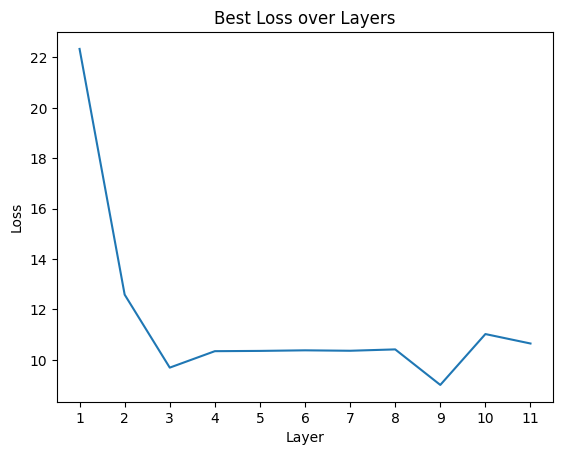

In [ ]:
# plot the best loss for each layer
best_losses.reverse()
print(best_losses)
plt.plot(range(1, len(best_losses) + 1), best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Layer")
plt.ylabel("Loss")

plt.xticks(range(1, 12))

plt.show()

# Testing 

In [ ]:
import matplotlib.pyplot as plt

# plot temperature predictions vs actual readings
def plot_actual_vs_pred(pred, actual):
    # specify number of samples to graph
    num_graphs = 10
    chunk_size = len(pred) // num_graphs

    # Create an appropriate number of plots
    for i in range(0, len(pred), chunk_size):
        plt.figure()
        
        plt.plot(pred[i], label='Predicted')
        plt.plot(actual[i], label='Actual')

        plt.title("Temperature: Predicted vs Actual")
        plt.xlabel("Silica Layer")
        plt.ylabel("Temperature (K)")
        
        plt.legend()
        plt.show()

Layer 11
sample_predictions: [324.5592956542969]
Layer 10
sample_predictions: [324.5592956542969, 314.58197021484375]
Layer 9
sample_predictions: [324.5592956542969, 314.58197021484375, 310.9166259765625]
Layer 8
sample_predictions: [324.5592956542969, 314.58197021484375, 310.9166259765625, 306.2913513183594]
Layer 7
sample_predictions: [324.5592956542969, 314.58197021484375, 310.9166259765625, 306.2913513183594, 305.30181884765625]
Layer 6
sample_predictions: [324.5592956542969, 314.58197021484375, 310.9166259765625, 306.2913513183594, 305.30181884765625, 307.7596130371094]
Layer 5
sample_predictions: [324.5592956542969, 314.58197021484375, 310.9166259765625, 306.2913513183594, 305.30181884765625, 307.7596130371094, 307.2987976074219]
Layer 4
sample_predictions: [324.5592956542969, 314.58197021484375, 310.9166259765625, 306.2913513183594, 305.30181884765625, 307.7596130371094, 307.2987976074219, 306.56805419921875]
Layer 3
sample_predictions: [324.5592956542969, 314.58197021484375, 31

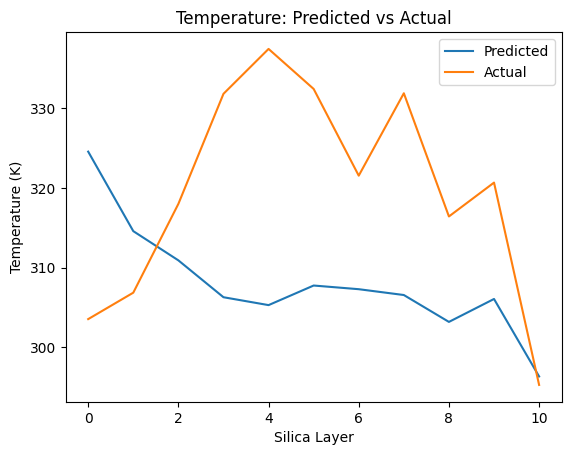

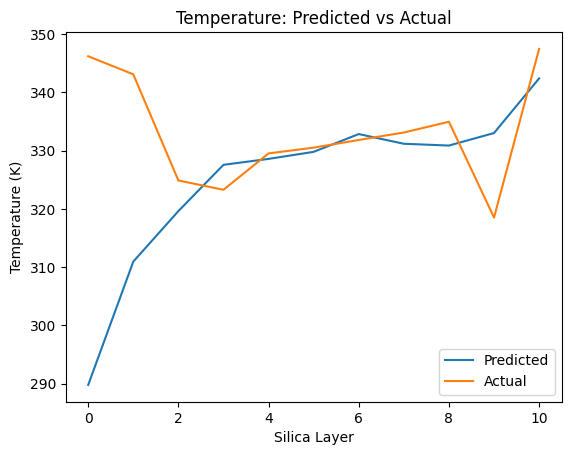

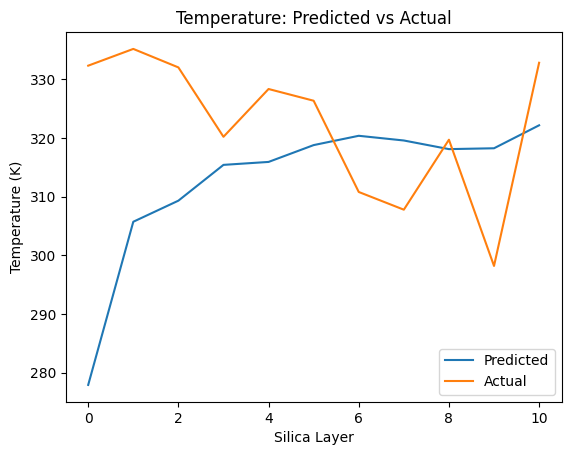

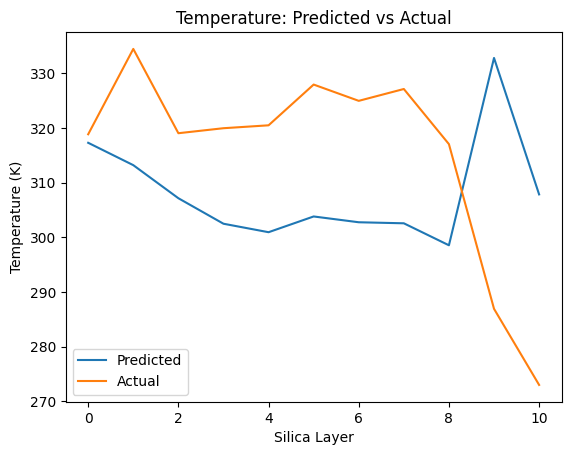

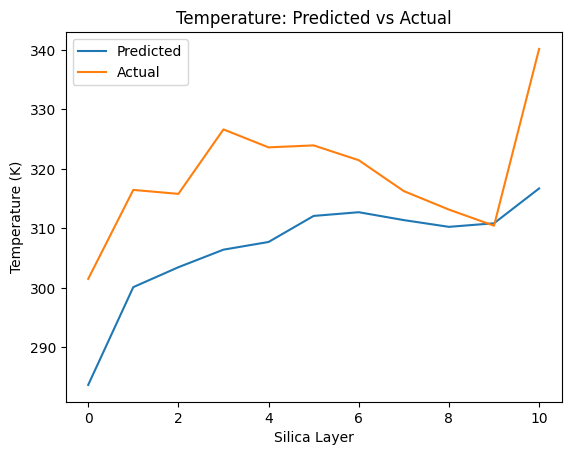

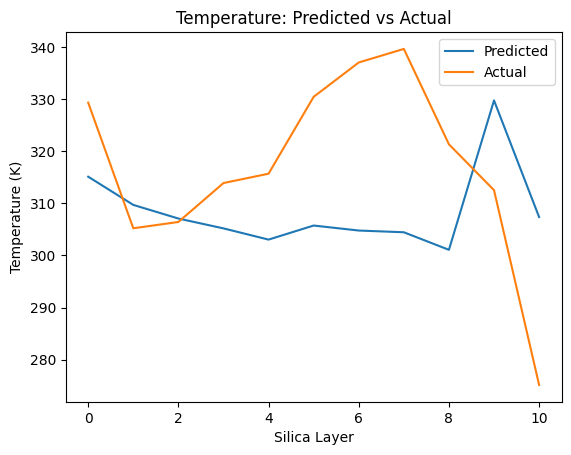

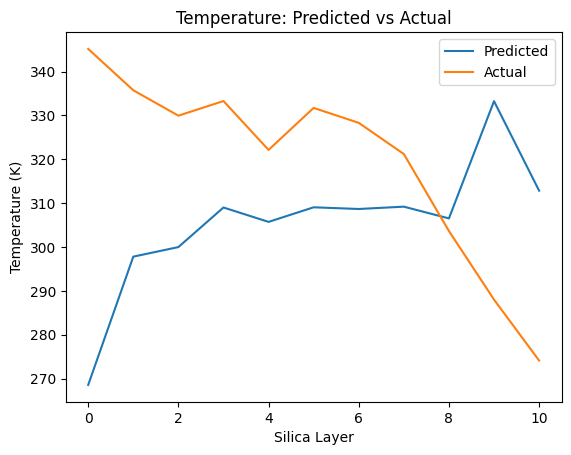

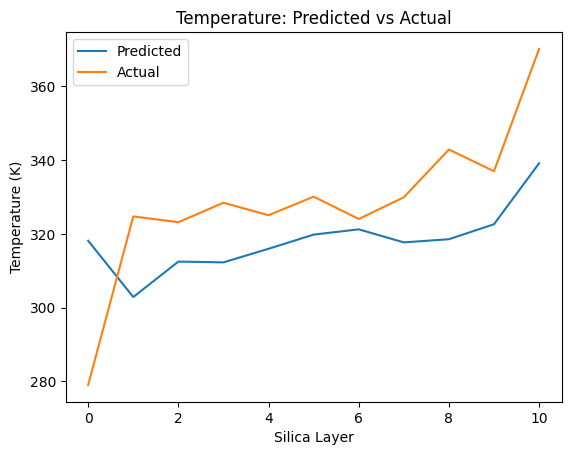

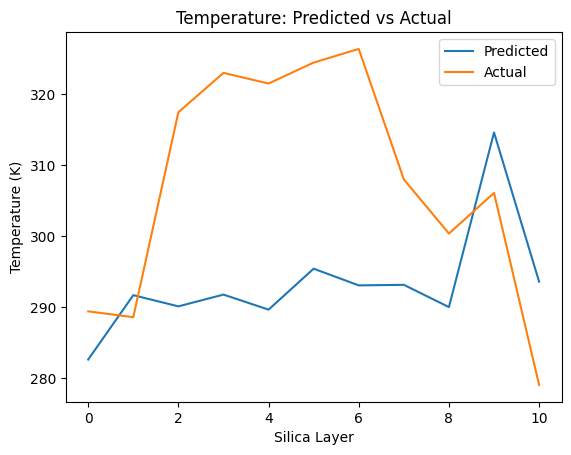

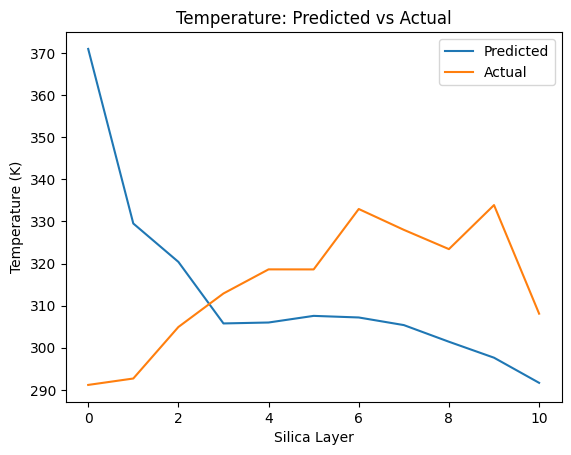

In [ ]:
# convert testing data to tensor
inputs = df_to_tensor(X_test)

# define prediction list (contains sublists for each sample) 
predictions = []

with torch.no_grad():
    for sample in inputs:
        # define new sample prediction list for each sample
        sample_prediction = []

        # iterate through layers to make temperature predictions for each layer sequentially
        for i in range(num_layers):
            layer = 11 - i
            print(f'Layer {layer}')

            # add previous layer's temperature prediction to inputs
            if i > 0:
                layer_pred_reshaped = layer_pred.reshape(1, -1)
                sample_reshaped = sample.reshape(1,-1)
                sample = torch.cat([sample_reshaped, layer_pred_reshaped], dim = 1)

            # define the model corresponding to the given layer
            model = models[f'model{layer}']

            # get temperature prediction and add to sample_prediction list
            layer_pred = model(sample)
            sample_prediction.append(layer_pred.item())
            print(f'sample_predictions: {sample_prediction}')
        
        # once all layers in a given sample have been predicted, add sublist to predictions list
        predictions.append(sample_prediction)

# plot results
actual = df_to_tensor(y_test).tolist()
plot_actual_vs_pred(predictions, actual)
